In [1]:
# 통합 파이프라인: 업로드 → 자동탐색 → 분포피팅(14종) → 히스토그램(최적분포 PDF) → 몬테카를로 → LECR 리포트
from google.colab import files
import os, re, json, math, warnings, glob
import numpy as np, pandas as pd
from scipy.stats import kstest
from scipy.stats import (
    gumbel_r, gumbel_l, lognorm, weibull_min, logistic,
    norm, gamma, beta, triang, expon, pareto, uniform, chi2
)
from scipy.stats import t as student_t
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
from openpyxl.worksheet.table import Table, TableStyleInfo
warnings.filterwarnings("ignore")

# ===================== 사용자 설정 =====================
np.random.seed(20250912)
N_SIM       = 10_000
BOOTSTRAP_B = 200
CD_INCLUDE  = True  # <-- Cd 포함/제외 스위치
SAVE_DIR    = "outputs"  # 결과 기본 폴더
# =====================================================

IUR = {"Cr(VI)":1.20e-02,"Co":9.00e-03,"Ni":2.40e-04,"As":4.30e-03,"Cd":1.80e-03,"Sb":2.29e-06,"Pb":1.20e-05}
ORDER = ['Cr','Cr(VI)','Co','Ni','As','Cd','Sb','Pb']

# 시트/열 자동탐색용 패턴 (헤더에 단위 포함 여부와 무관하게 금속명 탐지)
_UNIT_AFTER = r"(?=[^\w]*(?:\(|\[|\s|-|_)?\s*(?:n|u|μ)g\s*/?\s*m3)"
PAT = {
    "Cr(VI)": r"(?:\bCr\s*VI\b|\bCr\s*6\+|Hexa(?:valent)?\s*Chrom(?:ium)?)",
    "Cr"    : r"\bCr\b(?!\s*VI)",
    "Co"    : r"(?:\bCo\b|Cobalt|코발트)",
    "Ni"    : r"(?:\bNi\b|Nickel|니켈)",
    "As"    : r"(?:\bAs\b|Arsenic|비소)",
    "Cd"    : r"(?:\bCd\b|Cadmium|카드뮴)",
    "Sb"    : r"(?:\bSb\b|Antimony|안티몬)",
    "Pb"    : r"(?:\bPb\b|Lead|납)"
}
POS_ONLY = {'로그 정규','와이블','감마','지수','파레토'}

# Excel style
HEADER_BLUE = '2F5597'; BEST_FILL='FFF2CC'; THIN_GRAY='999999'; TABLE_STYLE="TableStyleMedium9"

# Exposure params
EF_days_per_year = 350; EF = EF_days_per_year/365.0
LT_years = 78.6
ACT_POINT = {"0-<1":24,"1-<2":84,"2-<3":120,"3-<6":108,"6-<11":132,"11-<16":102,"16-<18":102}  # min/day
ACT_LN_P5_P95 = {"18-<25":(14.455,250.0),"25-<35":(6.516,220.0),"35-<45":(5.789,195.0),
                 "45-<55":(6.401,260.0),"55-<65":(8.083,350.0),"65-<78.6":(6.094,390.0)}
ED_years = {"0-<1":1,"1-<2":1,"2-<3":1,"3-<6":3,"6-<11":5,"11-<16":5,"16-<18":2,
            "18-<25":7,"25-<35":10,"35-<45":10,"45-<55":10,"55-<65":10,"65-<78.6":13.6}
AGE_ORDER=["0-<1","1-<2","2-<3","3-<6","6-<11","11-<16","16-<18","18-<25","25-<35","35-<45","45-<55","55-<65","65-<78.6"]
INFANT = ["0-<1","1-<2"]; CHILD=["2-<3","3-<6","6-<11","11-<16","16-<18"]; ADULT=["18-<25","25-<35","35-<45","45-<55","55-<65","65-<78.6"]

# RNG helpers
_master_rs = np.random.RandomState(20250912)
def child_rs(): return np.random.RandomState(_master_rs.randint(0, 2**31-1))

# ---------- 업로드 & 시트 자동 선택 ----------
print("엑셀 파일 업로드(.xlsx/.xls)")
up = files.upload()
INPUT = next((k for k in up if k.lower().endswith(('.xlsx','.xls'))), None)
if INPUT is None:
    cand = sorted(glob.glob("*.xlsx"))
    if not cand: raise FileNotFoundError("엑셀 파일을 찾지 못했습니다.")
    INPUT = cand[-1]

# 후보 시트 점수화(메탈명 헤더 매칭 개수 최다 시트 선택)
xls = pd.ExcelFile(INPUT)
sheet_scores=[]
for sh in xls.sheet_names:
    df = pd.read_excel(INPUT, sheet_name=sh, nrows=3)
    score=0
    for c in df.columns:
        s=str(c)
        score += sum(bool(re.search(p, s, flags=re.I)) for p in PAT.values())
    sheet_scores.append((sh,score))
sheet_scores.sort(key=lambda x:x[1], reverse=True)
SHEET = sheet_scores[0][0]
raw = pd.read_excel(INPUT, sheet_name=SHEET)
print(f"선택된 시트: {SHEET}")

# ---------- 단위 통일 & 열 자동 매칭 ----------
def find_col(df, regex):
    for c in df.columns:
        if re.search(regex, str(c), flags=re.I): return c
    return None

def to_ug(series, name):
    s = pd.to_numeric(series, errors='coerce').replace([np.inf,-np.inf], np.nan)
    # 헤더에 ng 가 보이면 ng→µg 변환
    if re.search(r'(?i)ng/?m', str(name)) or re.search(r'(?i)\bng\b', str(name)):
        return (s/1000.0, 'converted_from_ng')
    return (s, 'as_is_ug')

def hist_mode_estimate(x):
    x=np.asarray(x,float); x=x[np.isfinite(x)]
    if x.size<2: return float(np.nanmedian(x)) if x.size else np.nan
    iqr=np.subtract(*np.percentile(x,[75,25]))
    bins=max(10,int(np.sqrt(x.size))) if iqr<=0 else max(10,int(np.ceil((x.max()-x.min())/(2*iqr*x.size**(-1/3)))))
    cnt,edges=np.histogram(x,bins=bins); i=int(cnt.argmax())
    return float((edges[i]+edges[i+1])/2)

series_map, log_rows = {}, []
for m in ORDER:
    if (m=='Cd') and (not CD_INCLUDE):  # Cd 제외 옵션 반영
        log_rows.append((m, None, 'excluded_by_flag', 0, np.nan)); continue
    c = find_col(raw, PAT.get(m, r"^"))
    if c is None:
        log_rows.append((m, None, 'missing', 0, np.nan)); continue
    v, how = to_ug(raw[c], c); series_map[m]=v
    log_rows.append((m, c, how, int(np.isfinite(v).sum()), float(np.nanmean(v))))
log = pd.DataFrame(log_rows, columns=['Metal','Matched_Column','Unit_Status','N_nonNa','Mean(ug/m3)'])

# Cr(VI) 생성 (존재하지 않으면 Cr/7)
if ('Cr(VI)' not in series_map) and ('Cr' in series_map):
    series_map['Cr(VI)'] = series_map['Cr']/7.0
    log.loc[len(log)] = ['Cr(VI)','(derived from Cr/7)','derived', int(np.isfinite(series_map['Cr(VI)']).sum()), float(np.nanmean(series_map['Cr(VI)']))]

# ---------- 14개 분포 래퍼 ----------
class D:
    def __init__(self,name): self.name=name; self.p={}; self.np=None; self.valid=False
    def ok(self,p,np_): self.p=p; self.np=np_; self.valid=True; return self
    def cdf(self,z): raise NotImplementedError
    def ppf(self,q): raise NotImplementedError
    def rvs(self,n,rs=None): raise NotImplementedError

class LogNormal(D):
    def __init__(self): super().__init__('로그 정규')
    def fit(self,x):
        x=np.asarray(x,float)
        x=x[np.isfinite(x) & (x>0)]
        if x.size<3: return self
        try: s,loc,sc=lognorm.fit(x, floc=0);
        except: return self
        if s>0 and sc>0: return self.ok({'s':s,'scale':sc},2)
        return self
    def cdf(self,z): return lognorm.cdf(z, s=self.p['s'], loc=0, scale=self.p['scale'])
    def ppf(self,q): return lognorm.ppf(q, s=self.p['s'], loc=0, scale=self.p['scale'])
    def rvs(self,n,rs=None): return lognorm.rvs(self.p['s'], loc=0, scale=self.p['scale'], size=n, random_state=rs)

class Weibull(D):
    def __init__(self): super().__init__('와이블')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x) & (x>0)]
        if x.size<3: return self
        try: c,loc,sc=weibull_min.fit(x, floc=0)
        except: return self
        if c>0 and sc>0: return self.ok({'c':c,'scale':sc},2)
        return self
    def cdf(self,z): return weibull_min.cdf(z, c=self.p['c'], loc=0, scale=self.p['scale'])
    def ppf(self,q): return weibull_min.ppf(q, c=self.p['c'], loc=0, scale=self.p['scale'])
    def rvs(self,n,rs=None): return weibull_min.rvs(self.p['c'], loc=0, scale=self.p['scale'], size=n, random_state=rs)

class Gamma_(D):
    def __init__(self): super().__init__('감마')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x) & (x>0)]
        if x.size<3: return self
        try: a,loc,sc=gamma.fit(x, floc=0)
        except: return self
        if a>0 and sc>0: return self.ok({'a':a,'scale':sc},2)
        return self
    def cdf(self,z): return gamma.cdf(z, a=self.p['a'], loc=0, scale=self.p['scale'])
    def ppf(self,q): return gamma.ppf(q, a=self.p['a'], loc=0, scale=self.p['scale'])
    def rvs(self,n,rs=None): return gamma.rvs(self.p['a'], loc=0, scale=self.p['scale'], size=n, random_state=rs)

class LogisticD(D):
    def __init__(self): super().__init__('로지스틱')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: loc,sc=logistic.fit(x)
        except: return self
        if sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return logistic.cdf(z, **self.p)
    def ppf(self,q): return logistic.ppf(q, **self.p)
    def rvs(self,n,rs=None): return logistic.rvs(size=n, **self.p, random_state=rs)

class NormalD(D):
    def __init__(self): super().__init__('정규')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: mu,sig=norm.fit(x)
        except: return self
        if sig>0: return self.ok({'loc':mu,'scale':sig},2)
        return self
    def cdf(self,z): return norm.cdf(z, **self.p)
    def ppf(self,q): return norm.ppf(q, **self.p)
    def rvs(self,n,rs=None): return norm.rvs(size=n, **self.p, random_state=rs)

class StudentT(D):
    def __init__(self): super().__init__('스튜던트의 t')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: df_,loc,sc=student_t.fit(x)
        except: return self
        if df_>0 and sc>0: return self.ok({'df':df_,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return student_t.cdf(z, **self.p)
    def ppf(self,q): return student_t.ppf(q, **self.p)
    def rvs(self,n,rs=None): return student_t.rvs(size=n, **self.p, random_state=rs)

class Exponential_(D):
    def __init__(self): super().__init__('지수')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x) & (x>0)]
        if x.size<3: return self
        try: loc,sc=expon.fit(x, floc=0)
        except: return self
        if sc>0: return self.ok({'scale':sc},1)
        return self
    def cdf(self,z): return expon.cdf(z, loc=0, scale=self.p['scale'])
    def ppf(self,q): return expon.ppf(q, loc=0, scale=self.p['scale'])
    def rvs(self,n,rs=None): return expon.rvs(size=n, loc=0, scale=self.p['scale'], random_state=rs)

class BetaPERT_(D):
    def __init__(self,lam=4.0): super().__init__('BetaPERT'); self.lam=lam
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        a,b=float(np.nanmin(x)),float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        m=float(np.clip(hist_mode_estimate(x), a+1e-9, b-1e-9))
        al=1+self.lam*(m-a)/(b-a); be=1+self.lam*(b-m)/(b-a)
        if al<=0 or be<=0: return self
        return self.ok({'a':a,'b':b,'alpha':al,'beta':be,'m':m},2)
    def cdf(self,z):
        zz=(z-self.p['a'])/(self.p['b']-self.p['a'])
        return beta.cdf(np.clip(zz,1e-9,1-1e-9), self.p['alpha'], self.p['beta'])
    def ppf(self,q): return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q, self.p['alpha'], self.p['beta'])
    def rvs(self,n,rs=None):
        r=beta.rvs(self.p['alpha'], self.p['beta'], size=n, random_state=rs)
        return self.p['a']+(self.p['b']-self.p['a'])*r

class Triangular_(D):
    def __init__(self): super().__init__('삼각형')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        a,b=float(np.nanmin(x)),float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        m=float(np.clip(hist_mode_estimate(x), a+1e-9, b-1e-9))
        c=(m-a)/(b-a)
        if not(0.0 < c < 1.0): return self
        # triang: shape=c, loc=a, scale=b-a
        return self.ok({'c':c,'loc':a,'scale':(b-a)},2)
    def cdf(self,z): return triang.cdf(z, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return triang.ppf(q, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return triang.rvs(self.p['c'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)

class Uniform_(D):
    def __init__(self): super().__init__('균일')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<2: return self
        a=float(np.nanmin(x)); b=float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        return self.ok({'loc':a,'scale':(b-a)},2)
    def cdf(self,z): return uniform.cdf(z, **self.p)
    def ppf(self,q): return uniform.ppf(q, **self.p)
    def rvs(self,n,rs=None): return uniform.rvs(size=n, **self.p, random_state=rs)

class GumbelR_(D):
    def __init__(self): super().__init__('최대 극값')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: loc,sc=gumbel_r.fit(x)
        except: return self
        if np.isfinite(loc) and sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return gumbel_r.cdf(z, **self.p)
    def ppf(self,q): return gumbel_r.ppf(q, **self.p)
    def rvs(self,n,rs=None): return gumbel_r.rvs(size=n, **self.p, random_state=rs)

class GumbelL_(D):
    def __init__(self): super().__init__('최소 극값')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: loc,sc=gumbel_l.fit(x)
        except: return self
        if np.isfinite(loc) and sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return gumbel_l.cdf(z, **self.p)
    def ppf(self,q): return gumbel_l.ppf(q, **self.p)
    def rvs(self,n,rs=None): return gumbel_l.rvs(size=n, **self.p, random_state=rs)

class Beta_(D):
    def __init__(self): super().__init__('베타')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        a=float(np.nanmin(x)); b=float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        z=np.clip((x-a)/(b-a), 1e-9, 1-1e-9)
        try: al,be,_,_ = beta.fit(z, floc=0, fscale=1)
        except: return self
        if (al>0) and (be>0): return self.ok({'a':a,'b':b,'alpha':al,'beta':be},2)
        return self
    def cdf(self,z):
        zz=(z-self.p['a'])/(self.p['b']-self.p['a'])
        return beta.cdf(np.clip(zz,1e-9,1-1e-9), self.p['alpha'], self.p['beta'])
    def ppf(self,q):
        return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q, self.p['alpha'], self.p['beta'])
    def rvs(self,n,rs=None):
        r=beta.rvs(self.p['alpha'], self.p['beta'], size=n, random_state=rs)
        return self.p['a']+(self.p['b']-self.p['a'])*r

class Pareto_(D):
    def __init__(self): super().__init__('파레토')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x) & (x>0)]
        if x.size<3: return self
        try: b,loc,sc=pareto.fit(x, floc=0)
        except: return self
        if b>0 and sc>0: return self.ok({'b':b,'scale':sc},2)
        return self
    def cdf(self,z): return pareto.cdf(z, b=self.p['b'], loc=0, scale=self.p['scale'])
    def ppf(self,q): return pareto.ppf(q, b=self.p['b'], loc=0, scale=self.p['scale'])
    def rvs(self,n,rs=None): return pareto.rvs(self.p['b'], loc=0, scale=self.p['scale'], size=n, random_state=rs)

# ---------- 적합도 통계 ----------
def AD_stat(x, cdf, eps=1e-12):
    x=np.sort(np.asarray(x,float)); n=x.size
    if n<5: return np.inf
    u=np.clip(cdf(x),eps,1-eps); i=np.arange(1,n+1)
    return float(-n - np.sum((2*i-1)*(np.log(u)+np.log(1-u[::-1])))/n)

def AD_p_boot_refit(x, dist_obj, B=BOOTSTRAP_B):
    x=np.asarray(x,float); x=x[np.isfinite(x)]
    n=x.size
    if n<5 or (not dist_obj.valid): return np.nan
    A2_obs=AD_stat(x, dist_obj.cdf); ge=0; m=0
    for _ in range(B):
        rs=child_rs(); xs=dist_obj.rvs(n, rs=rs)
        d=type(dist_obj)(); d.fit(xs)
        if not d.valid: continue
        A2_bs=AD_stat(xs, d.cdf); ge+=(A2_bs>=A2_obs); m+=1
    return float((ge+1)/(m+1)) if m>0 else np.nan

def KS_stat_p(x, d):
    try:
        D, p = kstest(x, lambda z: d.cdf(z))
        return float(D), float(p)
    except:
        return np.nan, np.nan

def Chi2_stat_p(x,d):
    try:
        n=len(x); N=max(5,min(50,n//5)); eps=1e-6
        qs=np.linspace(eps,1-eps,N+1); edges=np.unique(d.ppf(qs))
        if len(edges)<3: return np.nan,np.nan
        obs,_=np.histogram(x,bins=edges); exp=np.diff(qs)*n
        k=d.np or 0; df=len(obs)-1-k
        if df<=0: return np.nan,np.nan
        exp=np.maximum(exp[:len(obs)],1e-9)
        chi=np.sum((obs-exp)**2/exp); p=1.0-chi2.cdf(chi,df)
        return float(chi), float(p)
    except: return np.nan,np.nan

def pstr(name,p):
    try:
        if name=='로그 정규': return f"shape={p['s']:.5g}, scale={p['scale']:.5g}, loc=0"
        if name=='와이블':   return f"shape={p['c']:.5g}, scale={p['scale']:.5g}, loc=0"
        if name=='감마':     return f"shape={p['a']:.5g}, scale={p['scale']:.5g}, loc=0"
        if name=='지수':     return f"rate={1.0/p['scale']:.5g}"
        if name in ['최대 극값','최소 극값','정규','로지스틱']:
            lab='loc'; return f"{lab}={p['loc']:.5g}, scale={p['scale']:.5g}"
        if name=='스튜던트의 t': return f"loc={p['loc']:.5g}, scale={p['scale']:.5g}, df={p['df']:.5g}"
        if name=='베타':     return f"a={p.get('a'):.5g}, b={p.get('b'):.5g}, alpha={p['alpha']:.5g}, beta={p['beta']:.5g}"
        if name=='BetaPERT': return f"min={p['a']:.5g}, mode={p['m']:.5g}, max={p['b']:.5g}, alpha={p['alpha']:.5g}, beta={p['beta']:.5g}"
        if name=='삼각형':   return f"min={p['loc']:.5g}, mode≈{p['loc']+p['c']*p['scale']:.5g}, max={(p['loc']+p['scale']):.5g}"
        if name=='균일':     return f"min={p['loc']:.5g}, max={(p['loc']+p['scale']):.5g}"
        if name=='파레토':   return f"loc=0, scale={p['scale']:.5g}, shape={p['b']:.5g}"
        return json.dumps(p, ensure_ascii=False)
    except Exception:
        return json.dumps(p, ensure_ascii=False)

# ---------- 분포 피팅 & 랭킹 ----------
def fit_one(x):
    x=pd.Series(x, dtype=float).replace([np.inf,-np.inf], np.nan).dropna().values
    if x.size<20: return None
    cands=[LogNormal(),Gamma_(),Weibull(),LogisticD(),NormalD(),StudentT(),
           Exponential_(),BetaPERT_(),Triangular_(),Uniform_(),GumbelR_(),GumbelL_(),
           Beta_(), Pareto_()]
    rows=[]
    for d in cands:
        d.fit(x)
        if not d.valid:
            rows.append({'분포':d.name,'AD':np.inf,'ADp':np.nan,'KSp':-np.inf,'Chi2p':-np.inf,'np':1e9,'obj':d})
            continue
        xe = x[x>0] if d.name in POS_ONLY else x
        A2=AD_stat(xe, d.cdf); pAD=AD_p_boot_refit(xe, d, BOOTSTRAP_B)
        D,p=KS_stat_p(xe,d); chi,pc=Chi2_stat_p(xe,d)
        rows.append({'분포':d.name,'AD':A2,'ADp':pAD,'KSp':p,'Chi2p':pc,'np':d.np or 9,'obj':d})
    df=pd.DataFrame(rows)
    ksp_key  = -df['KSp'].fillna(0.0)
    chi2_key = -df['Chi2p'].fillna(0.0)
    df['_key'] = list(zip(df['AD'].fillna(np.inf), ksp_key, chi2_key, df['np'].fillna(np.inf)))
    df=df.sort_values('_key', kind='mergesort').drop(columns=['_key']).reset_index(drop=True)
    best=df.iloc[0]
    return best, df

fit_tables={}
for m in ORDER:
    if (m=='Cd') and (not CD_INCLUDE):
        fit_tables[m]={'best':None,'table':pd.DataFrame()}; continue
    s = series_map.get(m, None)
    if s is None:
        fit_tables[m]={'best':None,'table':pd.DataFrame()}; continue
    res=fit_one(s.values)
    if res is None:
        fit_tables[m]={'best':None,'table':pd.DataFrame()}
    else:
        best, df = res
        fit_tables[m]={'best':best,'table':df}

# ---------- 히스토그램 + 최적분포 PDF ----------
os.makedirs(SAVE_DIR, exist_ok=True); os.makedirs(f"{SAVE_DIR}/plots", exist_ok=True)

def plot_hist_with_fit(ax, data, dist_obj, title):
    x=np.asarray(pd.to_numeric(data, errors='coerce'),float)
    x=x[np.isfinite(x)]
    if x.size==0:
        ax.text(0.5,0.5,"No data",ha='center',va='center'); ax.set_title(title); return
    ax.hist(x, bins='auto', density=True, alpha=0.5, edgecolor='k')
    if dist_obj is not None and dist_obj.valid:
        xs = np.linspace(np.nanmin(x), np.nanmax(x), 400)
        ys = dist_obj.cdf(xs)  # we need pdf; derive by numerical diff to be robust
        # pdf from cdf numerical derivative to avoid param mistakes
        pdf = np.gradient(ys, xs)
        ax.plot(xs, pdf, lw=2, label=dist_obj.name)
        ax.legend()
    ax.set_title(title); ax.set_xlabel("Concentration (µg/m³)"); ax.set_ylabel("Density")
    ax.grid(True, alpha=0.25)

# 종합 4x2 패널
fig, axes = plt.subplots(4,2, figsize=(12,16))
axes = axes.ravel()
idx=0
for m in ORDER:
    if (m=='Cd') and (not CD_INCLUDE): continue
    data = series_map.get(m, pd.Series(dtype=float))
    dist = fit_tables.get(m,{}).get('table', pd.DataFrame())
    obj  = dist.iloc[0]['obj'] if (dist is not None and not dist.empty) else None
    plot_hist_with_fit(axes[idx], data, obj, m); idx+=1
    if idx>=8: break
while idx<8:
    axes[idx].axis('off'); idx+=1
fig.suptitle("Histograms with Best-Fit PDF", fontsize=16)
fig.tight_layout(rect=[0,0,1,0.97])
fig.savefig(f"{SAVE_DIR}/plots/Tx_fitting_summary.png", dpi=200)
plt.close(fig)

# 개별 저장
for m in ORDER:
    if (m=='Cd') and (not CD_INCLUDE): continue
    data = series_map.get(m, pd.Series(dtype=float))
    dist = fit_tables.get(m,{}).get('table', pd.DataFrame())
    obj  = dist.iloc[0]['obj'] if (dist is not None and not dist.empty) else None
    fig, ax = plt.subplots(figsize=(6,4))
    plot_hist_with_fit(ax, data, obj, m)
    fig.tight_layout()
    fig.savefig(f"{SAVE_DIR}/plots/{m}_fit.png", dpi=200)
    plt.close(fig)

# ---------- 피팅 결과 엑셀 (Tx_fit_result.xlsx) ----------
fit_xlsx = os.path.join(SAVE_DIR, f"Tx_fit_result_{'Cd_included' if CD_INCLUDE else 'Cd_excluded'}.xlsx")
wb=Workbook()
ws=wb.active; ws.title="Tx-적합도 보고서"
def set_col_widths(ws, widths):
    for col,w in widths.items(): ws.column_dimensions[col].width = w
def styled_header(ws, row, headers, start_col=1, fill_color=HEADER_BLUE):
    fill = PatternFill('solid', fgColor=fill_color); white = Font(color='FFFFFF', bold=True)
    center = Alignment(horizontal='center', vertical='center', wrap_text=True)
    thin = Border(left=Side(style='thin', color=THIN_GRAY), right=Side(style='thin', color=THIN_GRAY),
                  top=Side(style='thin', color=THIN_GRAY), bottom=Side(style='thin', color=THIN_GRAY))
    for j,h in enumerate(headers, start=start_col):
        c = ws.cell(row=row, column=j, value=h)
        c.fill = fill; c.font = white; c.alignment = center; c.border = thin
def write_num(ws, r, c, v, fmt='0.0000'):
    cell=ws.cell(row=r, column=c)
    if v is None or (isinstance(v,float) and (np.isnan(v) or np.isinf(v))): cell.value='---'
    else:
        cell.value=float(v) if isinstance(v,(int,float,np.floating)) else v
        if isinstance(v,(int,float,np.floating)): cell.number_format = fmt

set_col_widths(ws, {'A':18,'B':12,'C':10,'D':10,'E':10,'F':10,'G':12,'H':12,'I':64})
ws.freeze_panes = 'B3'
ws['A1'] = '순위: AD↓ → KS p↑ → χ² p↑ → #params↓'; ws['A2']='데이터 계열'
row=3; table_idx=1
for m in ORDER:
    ws.cell(row=row, column=1, value=m).font = Font(bold=True); row += 1
    headers=['분포','A-D','A-D P-값','K-S P-값','χ² P-값','모수수','매개변수']; styled_header(ws,row,headers,start_col=2); start_row=row; row+=1
    tbl = fit_tables.get(m,{}).get('table', pd.DataFrame())
    if tbl is None or tbl.empty:
        note = "(excluded)" if (m=='Cd' and not CD_INCLUDE) else "(no data or <20)"
        ws.cell(row=row, column=2, value=note); row+=2; continue
    for i,r_ in tbl.iterrows():
        rr=row+i
        ws.cell(row=rr, column=2, value=r_['분포'])
        write_num(ws, rr,3, r_['AD'])
        write_num(ws, rr,4, r_['ADp'])
        write_num(ws, rr,5, r_['KSp'])
        write_num(ws, rr,6, r_['Chi2p'])
        write_num(ws, rr,7, r_['np'], fmt='0')
        param_text = pstr(r_['분포'], r_['obj'].p)
        ws.cell(row=rr, column=8, value=param_text)
    end_row = row + len(tbl) - 1
    try:
        t = Table(displayName=f"T_{table_idx}", ref=f"B{start_row}:H{end_row}")
        t.tableStyleInfo = TableStyleInfo(name=TABLE_STYLE, showFirstColumn=False, showLastColumn=False,
                                          showRowStripes=True, showColumnStripes=False)
        ws.add_table(t); table_idx+=1
    except Exception: pass
    # 최적행 강조
    fill = PatternFill('solid', fgColor=BEST_FILL)
    if len(tbl)>0:
        for c in range(2,9): ws.cell(row=start_row+1, column=c).fill=fill
    row=end_row+2

# Log 시트
wsL = wb.create_sheet("Log")
wsL.append(list(log.columns))
for _,r in log.iterrows(): wsL.append(list(r.values))
wb.save(fit_xlsx)
print("Saved:", fit_xlsx)

# ---------- 몬테카를로: 농도 난수 ----------
C_sims={}
for m in ORDER:
    if (m=='Cd') and (not CD_INCLUDE): continue
    s = series_map.get(m, None)
    if s is None: continue
    info=fit_tables[m]['best']
    if (info is None) or (info.get('obj',None) is None) or (not info['obj'].valid):
        # 표본 재추출 방식 fallback
        x = pd.to_numeric(s, errors='coerce').dropna().values
        if x.size==0: continue
        idx=np.random.randint(0,len(x), size=N_SIM); C_sims[m]=x[idx]
    else:
        dist=info['obj']; C_sims[m]=dist.rvs(N_SIM, rs=child_rs())

if 'Cr(VI)' not in C_sims and 'Cr' in C_sims:
    C_sims['Cr(VI)']=C_sims['Cr']/7.0

# ---------- 활동시간 난수 → K 계산 ----------
_Z95=1.6448536269514722
def mu_sigma_from_p5p95(p5,p95):
    p5=max(1e-9,float(p5)); p95=max(1e-9,float(p95))
    if p95<=p5: p95=p5*1.01
    ln5,ln95=np.log(p5),np.log(p95); sigma=(ln95-ln5)/(2*_Z95); mu=(ln5+ln95)/2; return mu,sigma
def sample_AcTout(age, n):
    if age in ACT_POINT: return np.full(n, float(ACT_POINT[age]), dtype=float)
    p5,p95=ACT_LN_P5_P95[age]; mu,sg=mu_sigma_from_p5p95(p5,p95)
    return np.random.lognormal(mu,sg,size=n)

def K_by_group(n):
    Kg = {'Infant':np.zeros(n), 'Child':np.zeros(n), 'Adult':np.zeros(n)}
    for age in INFANT+CHILD+ADULT:
        act = sample_AcTout(age, n)  # min/day
        act_dayfrac = act / 1440.0
        add = act_dayfrac * EF * (ED_years[age]/LT_years) * (10.0 if age in INFANT else (3.0 if age in CHILD else 1.0))
        if age in INFANT: Kg['Infant'] += add
        elif age in CHILD: Kg['Child'] += add
        else: Kg['Adult'] += add
    Kg['Lifetime'] = Kg['Infant'] + Kg['Child'] + Kg['Adult']
    return Kg
Kg = K_by_group(N_SIM)

# ---------- LECR 계산 ----------
def summarize_risk(C_sims, Kg):
    out_rows=[]; cum_vec = np.zeros(N_SIM)
    for m in ORDER:
        if (m not in IUR) or (m not in C_sims): continue
        C = np.asarray(C_sims[m], float)
        ladd_tot = C * Kg['Lifetime']
        iur = float(IUR[m])
        lecr_tot = ladd_tot * iur
        cum_vec += lecr_tot
        def stats1(v):
            v=np.asarray(v,float); return dict(mean=float(np.mean(v)), median=float(np.median(v)),
                                               p95=float(np.percentile(v,95)), p99=float(np.percentile(v,99)))
        out_rows.append({'Metal': m, 'LECR (per metal)':  stats1(lecr_tot)})
    cum_stats = {'Total LECR': {'mean': float(np.mean(cum_vec)),
                                'median': float(np.median(cum_vec)),
                                'p95': float(np.percentile(cum_vec,95)),
                                'p99': float(np.percentile(cum_vec,99))}}
    return out_rows, cum_stats

risk_rows, cum_stats = summarize_risk(C_sims, Kg)

# ---------- LECR 엑셀 저장 ----------
lecr_xlsx = os.path.join(SAVE_DIR, "Tx.xlsx")
wb2 = Workbook(); wsR=wb2.active; wsR.title="LECR 결과 요약"
wsR.append(["Metal","mean","median","P95","P99"])
for r in risk_rows:
    m=r['Metal']; s=r['LECR (per metal)']; wsR.append([m,s['mean'],s['median'],s['p95'],s['p99']])
wsR2 = wb2.create_sheet("Total LECR")
wsR2.append(["metric","value"])
for k,v in cum_stats['Total LECR'].items(): wsR2.append([k,v])
wb2.save(lecr_xlsx)
print("Saved:", lecr_xlsx)

print("\n=== 완료 ===")
print(f"- 피팅 엑셀: {fit_xlsx}")
print(f"- LECR 엑셀: {lecr_xlsx}")
print(f"- 그림 폴더: {SAVE_DIR}/plots")

엑셀 파일 업로드(.xlsx/.xls)


Saving 202501_04_clean.xlsx to 202501_04_clean (7).xlsx
선택된 시트: Sheet1
Saved: outputs/Tx_fit_result_Cd_included.xlsx
Saved: outputs/Tx.xlsx

=== 완료 ===
- 피팅 엑셀: outputs/Tx_fit_result_Cd_included.xlsx
- LECR 엑셀: outputs/Tx.xlsx
- 그림 폴더: outputs/plots


In [3]:
# ---------- 콘솔 출력: 금속별 최적 분포 결과 ----------
print("\n=== 금속별 최적 분포 결과 요약 ===")
for m in ORDER:
    best = fit_tables.get(m, {}).get('best', None)
    if best is None or best.get('obj') is None:
        print(f"[{m}] 데이터 부족 또는 피팅 실패")
        continue
    dist_name = best['분포']
    ad, ksp, chi2p = best['AD'], best['KSp'], best['Chi2p']
    print(f"[{m}] ▶ {dist_name:8s} | AD={ad:.3f} | KS p={ksp:.3f} | χ² p={chi2p:.3f}")



=== 금속별 최적 분포 결과 요약 ===
[Cr] ▶ 지수       | AD=18.544 | KS p=0.000 | χ² p=0.000
[Cr(VI)] ▶ 지수       | AD=18.544 | KS p=0.000 | χ² p=0.000
[Co] ▶ 로그 정규    | AD=3.829 | KS p=0.017 | χ² p=0.000
[Ni] ▶ 지수       | AD=20.806 | KS p=0.000 | χ² p=0.000
[As] ▶ 스튜던트의 t  | AD=867.192 | KS p=0.000 | χ² p=0.000
[Cd] ▶ 로그 정규    | AD=52.140 | KS p=0.000 | χ² p=0.000
[Sb] ▶ 베타       | AD=2.682 | KS p=0.061 | χ² p=0.008
[Pb] ▶ 와이블      | AD=1.645 | KS p=0.063 | χ² p=0.000



                         C 검증(원자료 vs 시뮬레이션)

[C 검증] Cr
Raw              mean=0.0075428846, median=0.00449, p5=0.00029, p95=0.019688
Fitted(theory)   mean=0.0075458493, median=0.0052283292, p5=0.0003868994, p95=0.022596463
Simulated(C_sims) mean=0.0074677623, median=0.0051823852, p5=0.00040778601, p95=0.022132699


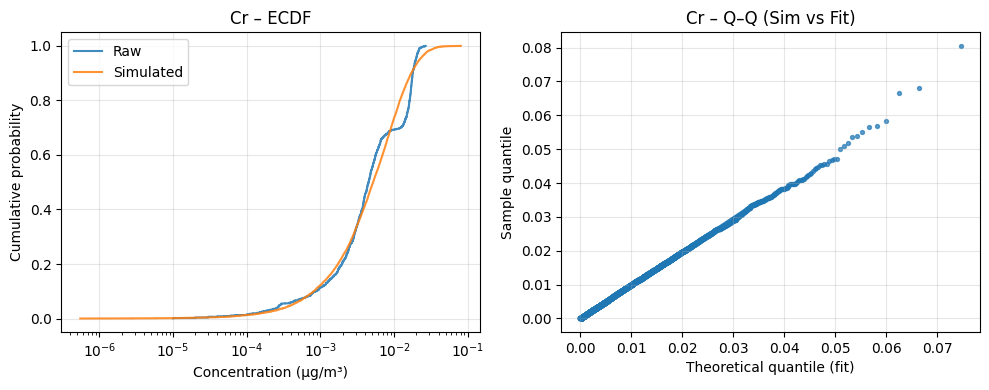


[C 검증] Cr(VI)
Raw              mean=0.0010775549, median=0.00064142857, p5=4.1428571e-05, p95=0.0028125714
Fitted(theory)   mean=0.0010779785, median=0.00074690417, p5=5.5271343e-05, p95=0.0032280661
Simulated(C_sims) mean=0.0010920385, median=0.00077199017, p5=5.6285408e-05, p95=0.0032812281


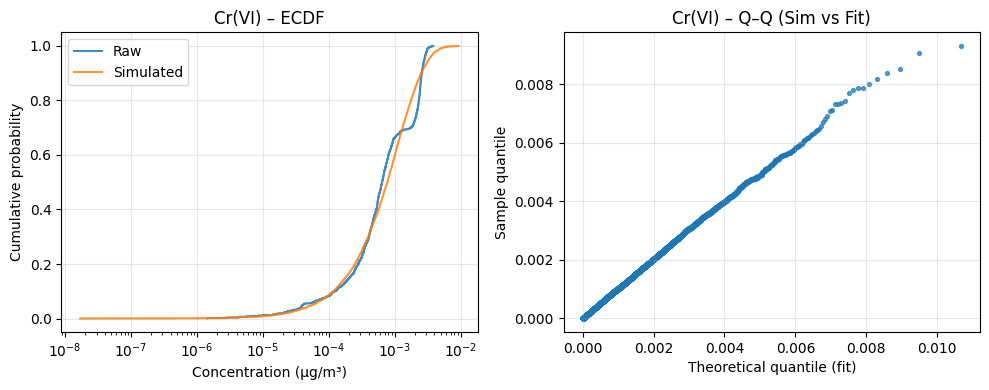


[C 검증] Co
Raw              mean=0.010015428, median=0.007825, p5=0.00236, p95=0.026395
Fitted(theory)   mean=0.01012145, median=0.0077081885, p5=0.002291085, p95=0.025933638
Simulated(C_sims) mean=0.010185301, median=0.0077641568, p5=0.0023138947, p95=0.02638334


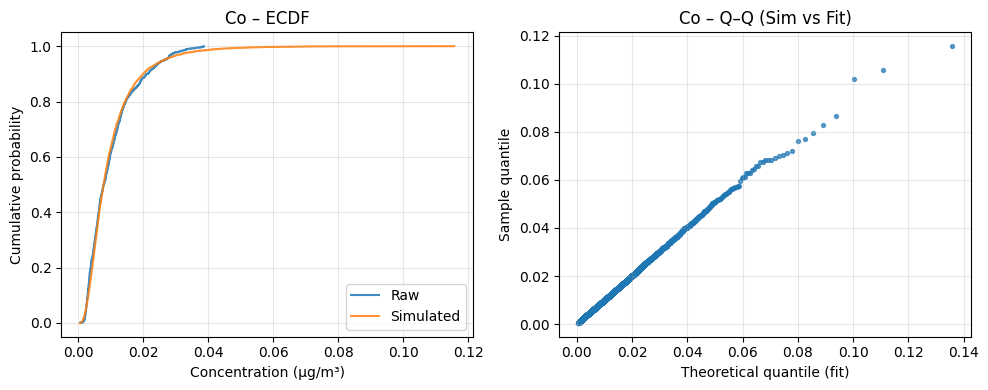


[C 검증] Ni
Raw              mean=0.0085486013, median=0.00519, p5=0.000445, p95=0.02084
Fitted(theory)   mean=0.0085764421, median=0.005942401, p5=0.00043974113, p95=0.02568263
Simulated(C_sims) mean=0.0088170713, median=0.0061145111, p5=0.00044619164, p95=0.026484641


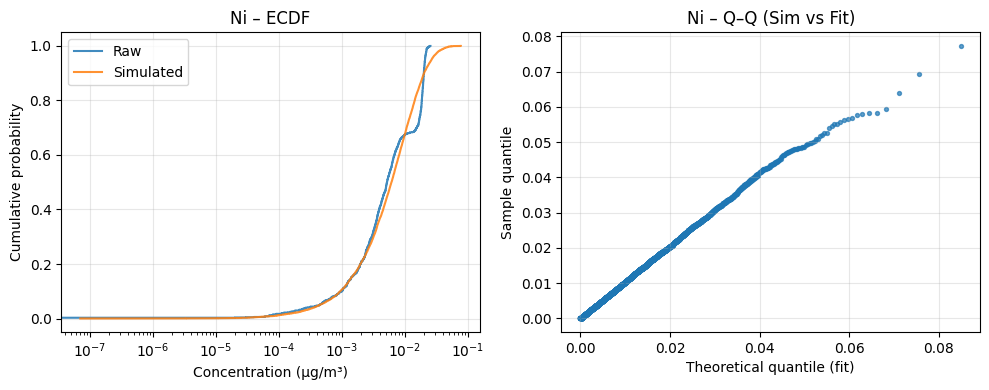


[C 검증] As
Raw              mean=0, median=0, p5=0, p95=0
Fitted(theory)   mean=-9.5197588e-22, median=-9.3958786e-22, p5=-5.2372177e-21, p95=3.3580419e-21
Simulated(C_sims) mean=-9.7237559e-22, median=-9.6168231e-22, p5=-5.2331517e-21, p95=3.2264246e-21


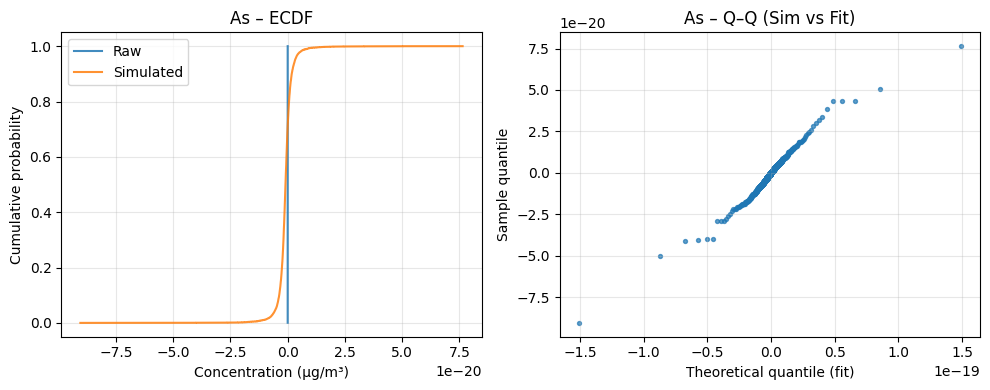


[C 검증] Cd
Raw              mean=0.30222432, median=0.22761, p5=0.133041, p95=0.656217
Fitted(theory)   mean=0.29915907, median=0.25839539, p5=0.10611064, p95=0.62923168
Simulated(C_sims) mean=0.30031708, median=0.25988784, p5=0.10710377, p95=0.62326498


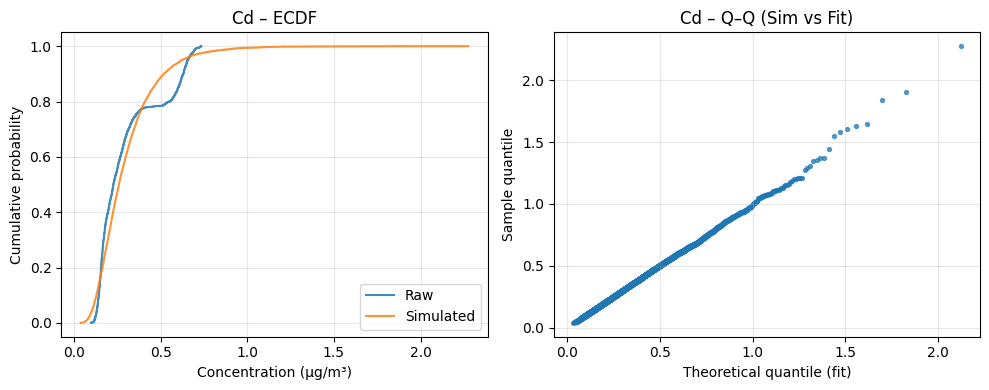


[C 검증] Sb
Raw              mean=0.042792941, median=0.031, p5=0.0024525, p95=0.114942
Fitted(theory)   mean=0.044508787, median=0.034656606, p5=0.0015245959, p95=0.12026333
Simulated(C_sims) mean=0.044649119, median=0.034877734, p5=0.001584679, p95=0.12073441


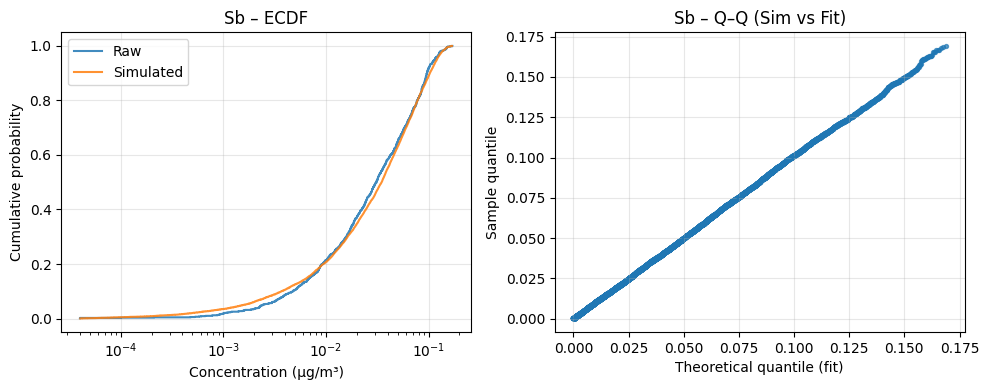


[C 검증] Pb
Raw              mean=0.0091271966, median=0.00691, p5=0.00044, p95=0.028288
Fitted(theory)   mean=0.0091415246, median=0.0064685823, p5=0.00051341569, p95=0.026877124
Simulated(C_sims) mean=0.0092530392, median=0.0064641929, p5=0.00049718301, p95=0.027283186


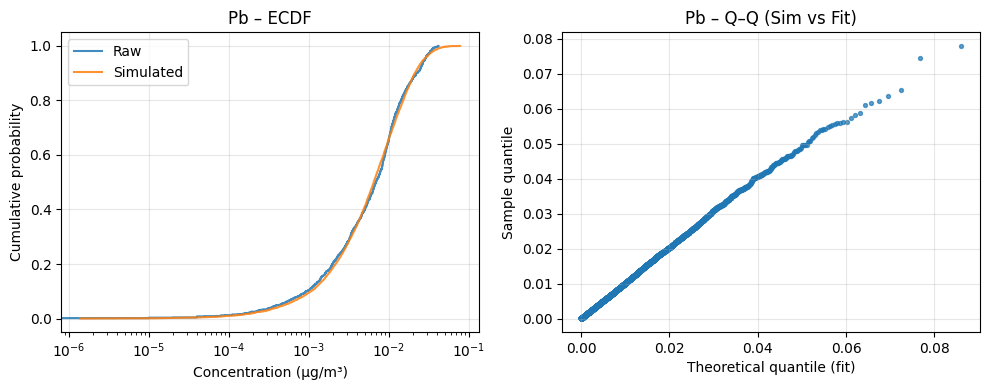

In [6]:
# ===== 금속별 C 시뮬레이션 검증: 텍스트 + ECDF & Q-Q =====
def qstats(x):
    x = np.asarray(pd.to_numeric(x, errors='coerce'), float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return {'mean': np.nan, 'median': np.nan, 'p5': np.nan, 'p95': np.nan}
    return {
        'mean': float(np.mean(x)),
        'median': float(np.median(x)),
        'p5': float(np.percentile(x,5)),
        'p95': float(np.percentile(x,95))
    }

def print_row(label, d):
    print(f"{label:<16} mean={d['mean']:.8g}, median={d['median']:.8g}, "
          f"p5={d['p5']:.8g}, p95={d['p95']:.8g}")

def ecdf(x):
    x = np.asarray(pd.to_numeric(x, errors='coerce'), float)
    x = x[np.isfinite(x)]
    x.sort()
    if x.size == 0:
        return x, x
    y = np.arange(1, x.size+1) / x.size
    return x, y

def fitted_ppf_summary(dist_obj):
    """피팅분포의 이론 5/50/95 분위 + 평균(샘플링 근사)."""
    p5  = float(dist_obj.ppf(0.05))
    p50 = float(dist_obj.ppf(0.50))
    p95 = float(dist_obj.ppf(0.95))
    rs = np.random.RandomState(12345)
    xs = dist_obj.rvs(200000, rs=rs)
    mean = float(np.mean(xs))
    return {'mean':mean, 'median':p50, 'p5':p5, 'p95':p95}

def qq_plot(ax, sample, dist_obj, title):
    x = np.asarray(pd.to_numeric(sample, errors='coerce'), float)
    x = x[np.isfinite(x)]
    if x.size < 5 or (dist_obj is None) or (not dist_obj.valid):
        ax.text(0.5,0.5,"(표본부족/피팅없음)", ha='center', va='center'); ax.set_title(title); return
    x.sort(); n = x.size
    probs = (np.arange(1,n+1)-0.5)/n
    theo = dist_obj.ppf(probs)
    ax.scatter(theo, x, s=8, alpha=0.7)
    lo,hi = np.nanpercentile(np.concatenate([theo,x]), [1,99])
    ax.plot([lo,hi],[lo,hi], lw=1)
    ax.set_xlabel("Theoretical quantile (fit)")
    ax.set_ylabel("Sample quantile")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

def validate_C_distributions():
    print("\n" + "="*74)
    print("                         C 검증(원자료 vs 시뮬레이션)")
    print("="*74)
    metals_to_check = [m for m in ORDER if m in C_sims]
    for m in metals_to_check:
        print(f"\n[C 검증] {m}")
        # 1) 원자료(전처리 열 그대로)
        raw_series = series_map.get(m, pd.Series(dtype=float))
        s_raw = qstats(raw_series)

        # 2) 피팅 이론 요약(가능하면)
        tbl = fit_tables.get(m, {}).get('table', pd.DataFrame())
        dist_obj = None; s_fit = None
        if (tbl is not None) and (not tbl.empty):
            dist_obj = tbl.iloc[0]['obj']
            if dist_obj and dist_obj.valid:
                s_fit = fitted_ppf_summary(dist_obj)

        # 3) 시뮬레이션 C
        csim = np.asarray(C_sims[m], float)
        s_sim = qstats(csim)

        # 텍스트 리포트
        print_row("Raw", s_raw)
        if s_fit:   print_row("Fitted(theory)", s_fit)
        else:       print("Fitted(theory)   없음/피팅불가")
        print_row("Simulated(C_sims)", s_sim)

        # ECDF & QQ 플롯
        fig, axs = plt.subplots(1,2, figsize=(10,4))
        # ECDF
        xs, ys = ecdf(raw_series); axs[0].step(xs, ys, where='post', label='Raw', alpha=0.85)
        xs2, ys2 = ecdf(csim);     axs[0].step(xs2,ys2,where='post',label='Simulated',alpha=0.85)
        try:
            spread = np.nanpercentile(xs2,95)/max(1e-12, np.nanpercentile(xs2,5))
            if spread > 20: axs[0].set_xscale('log')
        except: pass
        axs[0].set_title(f"{m} – ECDF")
        axs[0].set_xlabel("Concentration (µg/m³)"); axs[0].set_ylabel("Cumulative probability")
        axs[0].grid(True, alpha=0.3); axs[0].legend()

        # QQ
        qq_plot(axs[1], csim, dist_obj, f"{m} – Q–Q (Sim vs Fit)")
        plt.tight_layout()
        plt.show()

# 실행
validate_C_distributions()